# Machine Learning with Spark

#### Student no : 21827761 - 21827924
#### Student name : Burak Özüesen - Berkay Emre Turhan



## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

The aim of this assignment is to make us familiar with the basics of Apache Spark
and machine learning methods using Spark Environment.

In [40]:
# Setup Spark Phase

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [41]:
raw_data = spark.read.csv("Data/data.csv", header=True, inferSchema=True)
raw_data.toPandas().describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860154,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


Provide analysis and statistical information about the data set. How much data is there? What are the data types? What are the largest, smallest and average values of these data?

In [42]:
raw_data.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int32  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int32  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [43]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="Class", outputCol="Label")
model = stringIndexer.fit(raw_data)
OD = model.transform(raw_data)
class_view = OD.select('Class', 'Label').distinct()
OD = OD.drop("Class")
OD.show(5)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|  2.0|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

In [44]:
# Encoded class transformations shown below.
class_view.show()

+--------+-----+
|   Class|Label|
+--------+-----+
|    SIRA|  1.0|
|  BOMBAY|  6.0|
|    CALI|  4.0|
|   SEKER|  2.0|
|BARBUNYA|  5.0|
|DERMASON|  0.0|
|   HOROZ|  3.0|
+--------+-----+



We have applied simple encoding for class column, no other column have non-numeric feature so we do not have to encode anything else. We will perform min max scaling later for creating ND dataset.

# Min - Max Scaling

In [45]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

ND = OD.select("*")

for column in OD.columns:
    if column == "Label":
        continue

    column_max = OD.agg({column: "max"}).collect()[0][0]
    column_min = OD.agg({column: "min"}).collect()[0][0]

    scaler = udf(lambda x: (x-column_min)/(column_max-column_min), FloatType())
    ND = ND.withColumn(column, scaler(col(column)))
ND.show(5)

+-----------+-----------+---------------+---------------+------------+------------+-----------+-------------+----------+----------+----------+-----------+------------+------------+------------+------------+-----+
|       Area|  Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity| ConvexArea|EquivDiameter|    Extent|  Solidity| roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|
+-----------+-----------+---------------+---------------+------------+------------+-----------+-------------+----------+----------+----------+-----------+------------+------------+------------+------------+-----+
|0.034052674| 0.05857388|     0.04426214|     0.15214169|  0.12261211|  0.47779703|0.033107013|  0.070804134| 0.6710237|0.92282385|0.93482256| 0.78673315|   0.5934316|   0.8330487|  0.75099635|  0.98061985|  2.0|
| 0.03550018| 0.07755673|    0.030478805|     0.17833667|  0.05157739|    0.278472| 0.03499095|  0.073576905|  0.735504|0.87151366|0.79313797|  0.90

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

### Modeling for Clustering (OD)

In [46]:
from pyspark.ml.clustering import KMeans   # https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html
from pyspark.ml.feature import VectorAssembler

CLASS_SIZE = raw_data.select("Class").distinct().count()
print(f"Class size = {CLASS_SIZE}")

featuresCol = OD.columns[:-1]   # All columns except label
predictionCol = OD.columns[-1]  # Label

vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(OD)

kMeans = KMeans(k=CLASS_SIZE)
model = kMeans.fit(temp_df.select("features"))

COD = model.transform(temp_df)
COD = COD.drop("features")
COD.show(5)

Class size = 7
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+----------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|prediction|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+----------+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|  2.0|         0|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0

### Modeling for Clustering (ND)

In [47]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

CLASS_SIZE = raw_data.select("Class").distinct().count()
print(f"Class size = {CLASS_SIZE}")

featuresCol = ND.columns[:-1]   # All columns except label
predictionCol = ND.columns[-1]  # Label

vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(ND)

kMeans = KMeans(k=CLASS_SIZE)
model = kMeans.fit(temp_df.select("features"))

CND = model.transform(temp_df)
CND = CND.drop("features")
CND.show(5)

Class size = 7
+-----------+-----------+---------------+---------------+------------+------------+-----------+-------------+----------+----------+----------+-----------+------------+------------+------------+------------+-----+----------+
|       Area|  Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity| ConvexArea|EquivDiameter|    Extent|  Solidity| roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Label|prediction|
+-----------+-----------+---------------+---------------+------------+------------+-----------+-------------+----------+----------+----------+-----------+------------+------------+------------+------------+-----+----------+
|0.034052674| 0.05857388|     0.04426214|     0.15214169|  0.12261211|  0.47779703|0.033107013|  0.070804134| 0.6710237|0.92282385|0.93482256| 0.78673315|   0.5934316|   0.8330487|  0.75099635|  0.98061985|  2.0|         3|
| 0.03550018| 0.07755673|    0.030478805|     0.17833667|  0.05157739|    0.278472| 0.034

We used K-Means to cluster our dataset. We have chosen our K value as original dataset's unique class count. It is 7 in this case.

## Clustering results<a class="anchor" id="clustering"></a>

### Clustering Results (OD)

Best correlated column is Perimeter


<AxesSubplot:xlabel='Label', ylabel='Perimeter'>

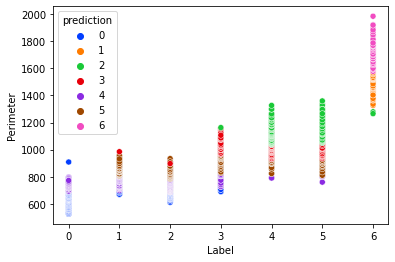

In [48]:
import seaborn as sns

cod_df = COD.toPandas()
best_correlated_column = cod_df.corr().loc["Label"].drop("Label").idxmax()
print(f"Best correlated column is {best_correlated_column}")
sns.scatterplot(data=cod_df, x="Label", y=best_correlated_column, hue="prediction", palette="bright")

### Clustering Results (ND)

Best correlated column is Perimeter


<AxesSubplot:xlabel='Label', ylabel='Perimeter'>

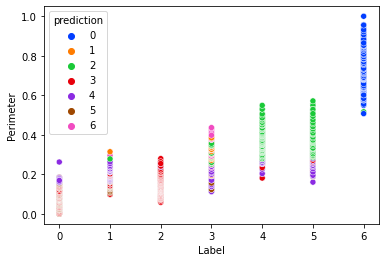

In [49]:
cnd_df = CND.toPandas()
best_correlated_column = cnd_df.corr().loc["Label"].drop("Label").idxmax()
print(f"Best correlated column is {best_correlated_column}")
sns.scatterplot(data=cnd_df, x="Label", y=best_correlated_column, hue="prediction", palette="bright")

In [50]:
# COD Accuracy

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictionAndLabels = COD.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
evaluator = MulticlassClassificationEvaluator()
print(f"Accuracy for COD dataset = {evaluator.evaluate(dataset)}")

# CND Accuracy

predictionAndLabels = CND.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
evaluator = MulticlassClassificationEvaluator()
print(f"Accuracy for CND dataset = {evaluator.evaluate(dataset)}")

Accuracy for COD dataset = 0.26661693693031313
Accuracy for CND dataset = 0.004894215512650785



## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

In [51]:
from pyspark.ml.classification import RandomForestClassifier    # https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.tree.RandomForest.html

### Classification for OD

In [52]:
featuresCol = OD.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(OD)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)

depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []

for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(train_set)
        preds = model.transform(val_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.7212753596462779 with number of 5 with 2 depth.
Score = 0.7304095077849502 with number of 10 with 2 depth.
Score = 0.734139131994994 with number of 20 with 2 depth.
Score = 0.8830706647984797 with number of 5 with 5 depth.
Score = 0.8975192800071801 with number of 10 with 5 depth.
Score = 0.8983821246469997 with number of 20 with 5 depth.
Score = 0.9114101188693107 with number of 5 with 10 depth.
Score = 0.9187533670011224 with number of 10 with 10 depth.
Score = 0.9200375890456035 with number of 20 with 10 depth.
Test Accuracy: 0.9196141254693743
Test Precision: 0.9145860709592641
Test Recall: 0.9405405405405406
Test F1-Score: 0.9196141254693743
Best Parameters: Depth = 10, Number of Trees = 20


### Classification for ND

In [53]:
featuresCol = ND.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(ND)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)

depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []

for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(train_set)
        preds = model.transform(val_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.7212753596462779 with number of 5 with 2 depth.
Score = 0.7304095077849502 with number of 10 with 2 depth.
Score = 0.734139131994994 with number of 20 with 2 depth.
Score = 0.8830706647984797 with number of 5 with 5 depth.
Score = 0.8975192800071801 with number of 10 with 5 depth.
Score = 0.8983821246469997 with number of 20 with 5 depth.
Score = 0.9114101188693107 with number of 5 with 10 depth.
Score = 0.9187533670011224 with number of 10 with 10 depth.
Score = 0.9200375890456035 with number of 20 with 10 depth.
Test Accuracy: 0.9196141254693743
Test Precision: 0.9145860709592641
Test Recall: 0.9405405405405406
Test F1-Score: 0.9196141254693743
Best Parameters: Depth = 10, Number of Trees = 20


### Classification for COD

In [56]:
COD = COD.drop("prediction")
featuresCol = COD.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(COD)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)

depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []

for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(train_set)
        preds = model.transform(val_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.7212753596462779 with number of 5 with 2 depth.
Score = 0.7304095077849502 with number of 10 with 2 depth.
Score = 0.734139131994994 with number of 20 with 2 depth.
Score = 0.8830706647984797 with number of 5 with 5 depth.
Score = 0.8975192800071801 with number of 10 with 5 depth.
Score = 0.8983821246469997 with number of 20 with 5 depth.
Score = 0.9114101188693107 with number of 5 with 10 depth.
Score = 0.9187533670011224 with number of 10 with 10 depth.
Score = 0.9200375890456035 with number of 20 with 10 depth.
Test Accuracy: 0.9196141254693743
Test Precision: 0.9145860709592641
Test Recall: 0.9405405405405406
Test F1-Score: 0.9196141254693743
Best Parameters: Depth = 10, Number of Trees = 20


### Classification for CND

In [55]:
CND = CND.drop("prediction")
featuresCol = CND.columns[:-1]
vecAssembler = VectorAssembler(inputCols=featuresCol, outputCol="features")
temp_df = vecAssembler.transform(CND)

train_set, test_set = temp_df.randomSplit([0.8, 0.2], seed=0)
train_set, val_set = train_set.randomSplit([0.8, 0.2], seed=0)

depths = [2, 5, 10]
num_trees = [5, 10, 20]
best_score = 0
best_model = None
best_params = []

for depth in depths:
    for num_tree in num_trees:
        rf = RandomForestClassifier(numTrees=num_tree, maxDepth=depth, featuresCol='features', labelCol="Label", predictionCol='prediction', leafCol="leafId")
        model = rf.fit(val_set)
        preds = model.transform(test_set)

        predictionAndLabels = preds.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
        dataset = spark.createDataFrame(predictionAndLabels.collect(), ["prediction", "label"])
        evaluator = MulticlassClassificationEvaluator()
        score = evaluator.evaluate(dataset)
        if score > best_score:
            best_score = score
            best_model = model
            best_params = [depth, num_tree]
        print(f"Score = {score} with number of {num_tree} with {depth} depth.")

# Test Eval
truths = best_model.transform(test_set)
truthsAndLabels = truths.rdd.map(lambda lp: (float(lp.prediction), float(lp.Label)))
test_dataset = spark.createDataFrame(truthsAndLabels.collect(), ["prediction", "label"])
test_score = evaluator.evaluate(test_dataset)
precision = evaluator.evaluate(test_dataset, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(test_dataset, {evaluator.metricName: "recallByLabel"})
f1_score = evaluator.evaluate(test_dataset, {evaluator.metricName: "f1"})
print(f"Test Accuracy: {test_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Best Parameters: Depth = {best_params[0]}, Number of Trees = {best_params[1]}")

Score = 0.7138998051316918 with number of 5 with 2 depth.
Score = 0.6260565862100254 with number of 10 with 2 depth.
Score = 0.6204696693029748 with number of 20 with 2 depth.
Score = 0.8830975305197772 with number of 5 with 5 depth.
Score = 0.8823888058842924 with number of 10 with 5 depth.
Score = 0.889289868089386 with number of 20 with 5 depth.
Score = 0.9050808796467291 with number of 5 with 10 depth.
Score = 0.908160660372501 with number of 10 with 10 depth.
Score = 0.915419394736443 with number of 20 with 10 depth.
Test Accuracy: 0.915419394736443
Test Precision: 0.916
Test Recall: 0.9283783783783783
Test F1-Score: 0.915419394736443
Best Parameters: Depth = 10, Number of Trees = 20


For each dataset Depth should be 10 and number of trees should be 20. Because this parameters has best validation scores.


**Disclaimer!** <font color='grey'>This notebook was prepared by Burak Özüesen, Berkay Emre Turhan as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>